In [8]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from PIL import Image

In [3]:
# split video into frames
import cv2
vidcap = cv2.VideoCapture('lane_video.mp4')
success,image = vidcap.read()
count = 0
if not success:
    print('failed')
while success:
  cv2.imwrite("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

In [12]:
# reduce images to 300x168 grayscale pixels
num_images = 1260

for i in range(num_images):
    basewidth = 300
    img = Image.open("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/frames/frame%d.jpg" % i)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    imgGray = img.convert('L')
    imgGray.save("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/reduced_frames/frame%d_reduced.jpg" % i)

In [15]:
# load in data
num_images = 1260

train = []
test = []
for i in range(num_images):
    img = Image.open("/Users/MattWalsh/Desktop/Files/School/CS6434/Project/reduced_frames/frame%d_reduced.jpg" % i)
    if np.random.rand() > 0.2:
        train.append(np.array(img))
    else:
        test.append(np.array(img))
        
trainX = np.asarray(train)
testX = np.asarray(test)

print(testX.shape)
print(trainX.shape)

(241, 168, 300)
(1019, 168, 300)


In [16]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [17]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
        name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

[INFO] building autoencoder...
Epoch 1/20
32/32 [==============================] - 60s 2s/step - loss: 0.0257 - val_loss: 0.0321
Epoch 2/20
32/32 [==============================] - 79s 2s/step - loss: 0.0136 - val_loss: 0.0307
Epoch 3/20
32/32 [==============================] - 63s 2s/step - loss: 0.0108 - val_loss: 0.0331
Epoch 4/20
32/32 [==============================] - 60s 2s/step - loss: 0.0085 - val_loss: 0.0321
Epoch 5/20
32/32 [==============================] - 62s 2s/step - loss: 0.0071 - val_loss: 0.0304
Epoch 6/20
32/32 [==============================] - 61s 2s/step - loss: 0.0063 - val_loss: 0.0296
Epoch 7/20
32/32 [==============================] - 61s 2s/step - loss: 0.0057 - val_loss: 0.0272
Epoch 8/20
32/32 [==============================] - 60s 2s/step - loss: 0.0052 - val_loss: 0.0250
Epoch 9/20
32/32 [==============================] - 60s 2s/step - loss: 0.0049 - val_loss: 0.0234
Epoch 10/20
32/32 [==============================] - 59s 2s/step - loss: 0.0045 - val_l

NameError: name 'args' is not defined

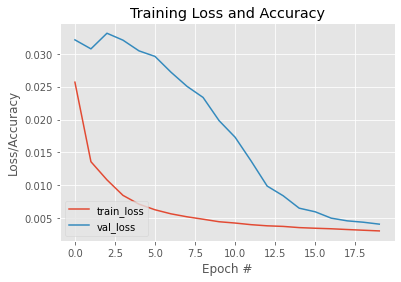

In [20]:
# training 
EPOCHS = 20
BS = 32
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(300, 168, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)


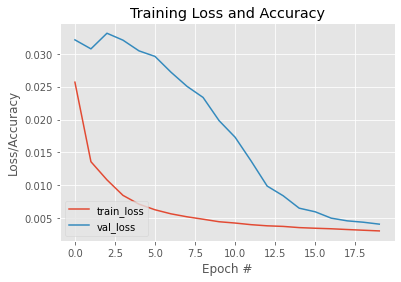

In [21]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Actual Image:


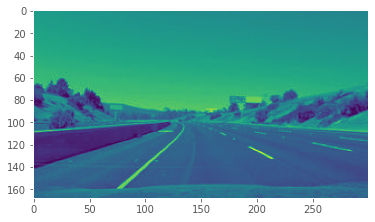

Image with Noise:
(168, 300, 1)


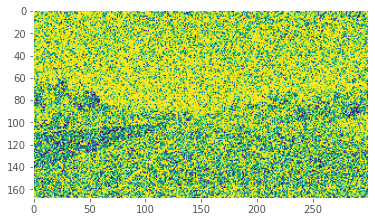

Reconstructed Image


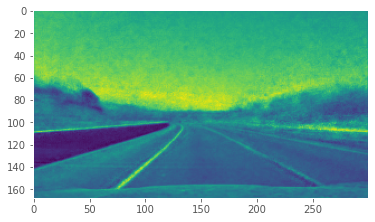

In [46]:
plt.grid(None)
print("Actual Image:")
plt.imshow(testX[0].reshape((168,300)))
plt.show()
print("Image with Noise:")
plt.grid(None)
plt.imshow(testXNoisy[0].reshape((168,300)))
print(testXNoisy[0].shape)
plt.show()
recon = autoencoder(testXNoisy[0].reshape(1,168,300,1)).numpy()
print("Reconstructed Image")
plt.grid(None)
plt.imshow(recon.reshape((168,300)))
plt.show()


